<a href="https://colab.research.google.com/github/greenkode/pytorch/blob/master/Chapter_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

In [22]:
transfer_model = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [23]:
for name, param in transfer_model.named_parameters():
  if("bn" not in name):
    param.requires_grad = False

In [25]:
transfer_model.fc = nn.Sequential(nn.Linear(transfer_model.fc.in_features, 500),
                                   nn.ReLU(),
                                   nn.Dropout(), nn.Linear(500, 2))

In [26]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    for epoch in range(epochs):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))

In [27]:
def check_image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False

In [28]:
img_transforms = transforms.Compose([
    transforms.Resize((64,64)),    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225] )
    ])
train_data_path = "./train/"
train_data = torchvision.datasets.ImageFolder(root=train_data_path,transform=img_transforms, is_valid_file=check_image)
val_data_path = "./val/"
val_data = torchvision.datasets.ImageFolder(root=val_data_path,transform=img_transforms, is_valid_file=check_image)
batch_size=64
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data_loader  = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

In [29]:
print(len(val_data_loader.dataset))

113


In [31]:
transfer_model.to(device)
optimizer = optim.Adam(transfer_model.parameters(), lr=0.001)

In [32]:
train(transfer_model, optimizer, torch.nn.CrossEntropyLoss(), train_data_loader, val_data_loader, epochs=5, device=device)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 0, Training Loss: 0.66, Validation Loss: 0.53, accuracy = 0.73
Epoch: 1, Training Loss: 0.26, Validation Loss: 0.26, accuracy = 0.88
Epoch: 2, Training Loss: 0.12, Validation Loss: 0.34, accuracy = 0.88
Epoch: 3, Training Loss: 0.06, Validation Loss: 0.30, accuracy = 0.88
Epoch: 4, Training Loss: 0.04, Validation Loss: 0.17, accuracy = 0.94


### **LR Finder**

In [38]:
def find_lr(model, loss_fn, optimizer, train_loader, init_value=1e-8, final_value=10.0, device="cpu"):
    number_in_epoch = len(train_loader) - 1
    update_step = (final_value / init_value) ** (1 / number_in_epoch)
    lr = init_value
    optimizer.param_groups[0]["lr"] = lr
    best_loss = 0.0
    batch_num = 0
    losses = []
    log_lrs = []
    for data in train_loader:
        batch_num += 1
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        # Crash out if loss explodes

        if batch_num > 1 and loss > 4 * best_loss:
            if(len(log_lrs) > 20):
                return log_lrs[10:-5], losses[10:-5]
            else:
                return log_lrs, losses

        # Record the best loss

        if loss < best_loss or batch_num == 1:
            best_loss = loss

        # Store the values
        losses.append(loss.item())
        log_lrs.append((lr))

        # Do the backward pass and optimize

        loss.backward()
        optimizer.step()

        # Update the lr for the next step and store

        lr *= update_step
        optimizer.param_groups[0]["lr"] = lr
    if(len(log_lrs) > 20):
        return log_lrs[10:-5], losses[10:-5]
    else:
        return log_lrs, losses

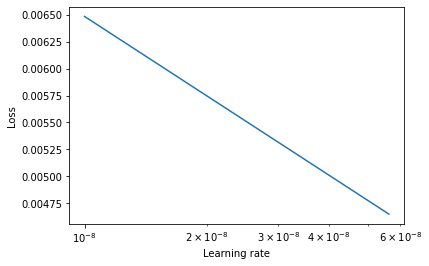

In [39]:
(lrs, losses) = find_lr(transfer_model, torch.nn.CrossEntropyLoss(), optimizer, train_data_loader, device=device)
plt.plot(lrs, losses)

plt.xscale("log")
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.show()